In [1]:
# Import experimental feature first
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from mrmr import mrmr_classif

# Re-run the rest of the code now that IterativeImputer is properly enabled
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, GenericUnivariateSelect, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay,
    average_precision_score
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import optuna
from scipy.stats import gaussian_kde

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from tqdm import tqdm

import pymysql.cursors
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import clear_output
from sklearn.utils import resample

from connections import *
import pickle

# ELIMINAR FEATURES REDUNDANTES

In [2]:
# ==== 1) Create 5 random probes ====
def add_random_probes(X: pd.DataFrame, n_probes: int = 5, seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    X_aug = X.copy()
    for i in range(n_probes):
        X_aug[f"rand_probe_{i+1}"] = rng.normal(loc=0.0, scale=1.0, size=len(X_aug))
    return X_aug

# ==== 2) Iterative Imputer ====
def minimal_preprocess(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    """
    Solo imputación iterativa sobre todas las columnas (asumidas numéricas).
    Devuelve un DataFrame numérico sin NaNs, listo para VT + mRMR.
    """
    imputer = IterativeImputer(max_iter=1000, random_state=42)
    X_imputed = imputer.fit_transform(X, y)
    return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# ==== 3) Variance Threshold ====
def apply_variance_threshold(X_num: pd.DataFrame, threshold: float = 0.01) -> pd.DataFrame:
    vt = VarianceThreshold(threshold=threshold)
    Xt = vt.fit_transform(X_num.values)
    kept_mask = vt.get_support()
    kept_cols = X_num.columns[kept_mask]
    return pd.DataFrame(Xt, columns=kept_cols, index=X_num.index)

# ==== 4) mRMR ranking ====
def run_mrmr_ranking(X_num: pd.DataFrame, y: pd.Series, K: int | None = None) -> list[str]:
    """
    mrmr_classif devuelve lista de nombres ordenados (mejor → peor).
    Asegúrate de pasar DataFrame numérico sin NaNs.
    """
    if K is None:
        K = X_num.shape[1]
    return mrmr_classif(X=X_num, y=y, K=K)

# ==== 5) Filter agains probes ====
def filter_below_random_probes(ranking: list[str], probe_prefix: str = "rand_probe_") -> list[str]:
    """
    Mantiene solo las variables con ranking mejor que la peor random probe.
    Si no hay probes (o no están en el ranking), no filtra nada.
    """
    probe_positions = [i for i, f in enumerate(ranking) if f.startswith(probe_prefix)]
    if not probe_positions:
        return ranking  # no probes presentes
    worst_probe_pos = max(probe_positions)  # índice más alto = peor entre las probes
    return [f for i, f in enumerate(ranking) if i < worst_probe_pos and not f.startswith(probe_prefix)]

# ==== 6) Pipeline end-to-end ====
def feature_reduction_workflow(X_raw: pd.DataFrame, y: pd.Series,
                               n_probes: int = 5,
                               vt_threshold: float = 0.01,
                               seed: int = 42) -> dict:
    """
    Devuelve:
      - X_final: DataFrame reducido tras VT + mRMR + filtro contra probes
      - ranking_all: ranking mRMR completo (incluyendo probes)
      - kept_features: lista final de columnas mantenidas (sin probes)
      - removed_by_vt: variables reales eliminadas por Variance Threshold
      - removed_by_mrmr: variables reales eliminadas por el filtro mRMR (tras VT)
      - removed_probes_by_vt: probes eliminadas por VT
      - removed_probes_by_mrmr: probes eliminadas por el filtro mRMR (tras VT)
      - vt_kept_features: columnas que sobrevivieron a VT (incluye probes si sobrevivieron)
    """
    # Helper
    def is_probe(name: str) -> bool:
        return str(name).startswith("rand_probe_")

    # 1) Add probes
    X_aug = add_random_probes(X_raw, n_probes=n_probes, seed=seed)

    # 2) Imputation
    X_pp = minimal_preprocess(X_aug, y)
    pp_cols = list(X_pp.columns)

    # 3) Variance Threshold
    X_vt = apply_variance_threshold(X_pp, threshold=vt_threshold)
    vt_kept_features = list(X_vt.columns)

    # --- Removed by VT ---
    removed_by_vt_all = [c for c in pp_cols if c not in vt_kept_features]
    removed_by_vt = [c for c in removed_by_vt_all if not is_probe(c)]
    removed_probes_by_vt = [c for c in removed_by_vt_all if is_probe(c)]

    # 4) mRMR
    ranking_all = run_mrmr_ranking(X_vt, y, K=X_vt.shape[1])

    # 5) Filter by random probes (we keep the features ranked better thant the worst probe)
    kept_features_with_probes = filter_below_random_probes(ranking_all, probe_prefix="rand_probe_")

    # 6) Final features without probes
    kept_features = [f for f in kept_features_with_probes if not is_probe(f)]
    X_final = X_vt[kept_features].copy()

    # --- Removed by mRMR---
    removed_by_mrmr_all = [c for c in vt_kept_features if c not in kept_features]
    removed_by_mrmr = [c for c in removed_by_mrmr_all if not is_probe(c)]
    removed_probes_by_mrmr = [c for c in removed_by_mrmr_all if is_probe(c)]

    return {
        "X_final": X_final,
        "ranking_all": ranking_all,
        "kept_features": kept_features,
        "removed_by_vt": removed_by_vt,
        "removed_by_mrmr": removed_by_mrmr,
        "removed_probes_by_vt": removed_probes_by_vt,
        "removed_probes_by_mrmr": removed_probes_by_mrmr,
        "vt_kept_features": vt_kept_features,
    }

# ==== 7) Run the pipeline for -24h, -48h and -72h windows ====
def run_by_window(df: pd.DataFrame,
                  n_probes: int = 5, vt_threshold: float = 0.01) -> dict:

    df_hr = df[df["hr"].isin([-24, -48, -72])].drop(columns=["PatientID", "hr"], errors="ignore")
        
    y = df_hr["NAV"].astype(int)
    X = df_hr.drop(columns=["NAV"], errors="ignore")
    return feature_reduction_workflow(X, y, n_probes=n_probes, vt_threshold=vt_threshold)

def downsampling(X_train, y_train, majority_proportion=1.0):
    """
    Performs downsampling on the majority class to balance the dataset.
    
    Parameters:
    X_train (array-like): Feature matrix of the training data.
    y_train (array-like): Label array corresponding to the training data.
    majority_proportion (float or None): 
        - If float, ratio of majority class to minority class (e.g. 1.0 means balanced).
        - If None, no downsampling is performed.

    Returns:
    tuple: Downsampled (or original) feature matrix and label array as numpy arrays.
    """
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)

    if majority_proportion is None:
        return X_train, y_train

    # Separate minority and majority class samples
    X_minority = X_train[y_train == 1]
    X_majority = X_train[y_train != 1]
    y_majority = y_train[y_train != 1]

    # Calculate number of majority class samples to keep
    desired_majority_samples = int(len(X_minority) * majority_proportion)

    # Downsample majority class
    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=desired_majority_samples,
        random_state=42
    )

    # Combine minority and downsampled majority
    X_balanced = np.vstack((X_minority, X_majority_downsampled))
    y_balanced = np.hstack((np.ones(len(X_minority)), y_majority_downsampled))

    return X_balanced, y_balanced

# GET RANKED FEATURES

In [3]:
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
}

selectors = {
    'mRMR': lambda k: 'mRMR',
    'SelectKBest_f': lambda k: SelectKBest(score_func=f_classif, k=k),
    'SelectKBest_MI': lambda k: SelectKBest(score_func=mutual_info_classif, k=k),
    'GenericUnivariateSelect': lambda k: GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=k),
    'VarianceThreshold': lambda k: VarianceThreshold(threshold=0.01),
    'ModelBased_XGB': lambda k: 'ModelBased_XGB',
    'ModelBased_LGBM': lambda k: 'ModelBased_LGBM',
    'ModelBased_RF': lambda k: 'ModelBased_RF',
    'ModelBased_CatBoost': lambda k: 'ModelBased_CatBoost',
    'ModelBased_ExtraTrees': lambda k: 'ModelBased_ExtraTrees',
}

# Feature ranking function
def get_ranked_features(X, y, method):
    if method == "SelectKBest_f":
        selector = SelectKBest(score_func=f_classif, k='all')
        selector.fit(X, y)
        scores = selector.scores_
        return list(X.columns[np.argsort(scores)[::-1]])
    elif method == "SelectKBest_MI":
        selector = SelectKBest(score_func=mutual_info_classif, k='all')
        selector.fit(X, y)
        scores = selector.scores_
        return list(X.columns[np.argsort(scores)[::-1]])
    elif method == "GenericUnivariateSelect":
        selector = GenericUnivariateSelect(score_func=f_classif, mode='k_best', param='all')
        selector.fit(X, y)
        scores = selector.scores_
        return list(X.columns[np.argsort(scores)[::-1]])
    elif method == "VarianceThreshold":
        variances = X.var()
        return list(X.columns[np.argsort(variances.values)[::-1]])
    elif method == "ModelBased_XGB":
        model = XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0)
        model.fit(X, y)
        importances = model.feature_importances_
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_LGBM":
        model = LGBMClassifier(random_state=42, verbose=-1)
        model.fit(X, y)
        importances = model.booster_.feature_importance(importance_type='gain')
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_RF":
        model = RandomForestClassifier(random_state=42, verbose=0)
        model.fit(X, y)
        importances = model.feature_importances_
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_CatBoost":
        model = CatBoostClassifier(random_state=42, verbose=0)
        model.fit(X, y)
        importances = model.get_feature_importance()
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_ExtraTrees":
        model = ExtraTreesClassifier(random_state=42, verbose=0)
        model.fit(X, y)
        importances = model.feature_importances_
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "mRMR":
        return mrmr_classif(X, y, K=X.shape[1])
    else:
        raise ValueError(f"Método de selección desconocido: {method}")

# EXTRACT FEATURES

In [4]:
ranked_features = {}

# ========== LOAD AND DATA PROCESSING ==========
df = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
no_significativas = [
    
    # variables with more than 30% missings
    "pct_median", "pct_min", "pct_max",

    # non-significant categorical variables in 24h prior the event
    "AdmType_scheduled", "AdmType_urgent",
    "MPOC",
    "dias_VMI",
    "ICU_days",
    "exitus",
    "consistencia_secreciones_altres", "consistencia_secreciones_espesses", "consistencia_secreciones_fluides", "consistencia_secreciones_taps_de_moc",
    "reintubacion"
]
df.drop(columns=no_significativas, inplace=True)

res = run_by_window(df, n_probes = 10)
lista_features = res['kept_features']

df = df[['PatientID', 'hr', 'NAV'] + lista_features].copy()

for hr in [-1, -24 , -48]:

    df_hr = df[df['hr'] == hr].drop(columns=['PatientID', 'hr'], axis=1).reset_index(drop=True)
    X = df_hr.drop(columns=['NAV'], axis=1)
    y = df_hr['NAV']
    columns = list(X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    imputer = IterativeImputer(max_iter=1000, random_state=42)
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)
    
    X_train, y_train = downsampling(X_train.values, y_train, majority_proportion=1.0)
    X_train = pd.DataFrame(X_train, columns=columns)
    
    hr_str = f"hr={hr}"
    ranked_features[hr_str] = {}
    for selector_name, scores in selectors.items():
        ranked_features[hr_str][selector_name] = get_ranked_features(X_train, y_train, selector_name)

100%|██████████| 64/64 [00:04<00:00, 14.79it/s]


# MODEL HYPERPARAMETER TUNNING

https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/

## MODEL -1H

In [5]:
n_features = 32
best_feature_selector = 'ModelBased_CatBoost'

features_finales_1h = ranked_features['hr=-1'][best_feature_selector][:n_features]
features_finales_1h_nav = features_finales_1h.copy()
features_finales_1h_nav.extend(['NAV'])

In [6]:
df = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_training = df[df.hr==-1].reset_index(drop=True)

lista_pacientes = df_training.PatientID.unique()
df_test_24 = df[(df.PatientID.isin(lista_pacientes)) & (df.hr==-24)].reset_index(drop=True)

df_training = df_training[features_finales_1h_nav]
df_test_24 = df_test_24[features_finales_1h_nav]

In [7]:
X = df_training.drop("NAV", axis=1).copy()
y = df_training["NAV"].copy()
X_24 = df_test_24.drop("NAV", axis=1).copy()
y_24 = df_test_24["NAV"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.2, random_state=42, stratify=y_24)

In [8]:
def objective(trial):
    # Espacio de hiperparámetros para CatBoost
    param_space = {
        'depth': trial.suggest_int('depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0, step=0.1)
    }

    # Hiperparámetros adicionales
    majority_proportion = trial.suggest_categorical('majority_proportion', [0.8, 0.9, 1.0, 1.1, 1.2])
    n_folds = trial.suggest_categorical('n_folds', [3, 4, 5])

    # Validación cruzada
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    pr_aucs = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx].copy(), X_train.iloc[valid_idx].copy()
        y_train_fold, y_valid_fold = y_train.iloc[train_idx].copy(), y_train.iloc[valid_idx].copy()
        X_train_fold_24, X_valid_fold_24 = X_train_24.iloc[train_idx].copy(), X_train_24.iloc[valid_idx].copy()
        y_train_fold_24, y_valid_fold_24 = y_train_24.iloc[train_idx].copy(), y_train_24.iloc[valid_idx].copy()

        # Imputación sin leakage
        imputer = IterativeImputer(max_iter=1000, random_state=42)
        X_train_fold = imputer.fit_transform(X_train_fold)
        # X_valid_fold = imputer.transform(X_valid_fold)
        X_valid_fold_24 = imputer.transform(X_valid_fold_24)

        # Downsampling dentro del fold
        X_train_fold, y_train_fold = downsampling(X_train_fold, y_train_fold, majority_proportion=majority_proportion)

        # Entrenamiento y evaluación
        model = CatBoostClassifier(
            **param_space,
            verbose=0,
            random_state=42,
        )
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba = model.predict_proba(X_valid_fold_24)[:, 1]

        # PR-AUC
        pr_auc = average_precision_score(y_valid_fold_24, y_pred_proba)
        pr_aucs.append(pr_auc)

    return np.mean(pr_aucs)

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-08-31 21:59:41,703] A new study created in memory with name: no-name-2f0e135a-fc79-4670-93b2-5a0f233b1b1e
[I 2025-08-31 21:59:46,411] Trial 0 finished with value: 0.3695716056727987 and parameters: {'depth': 4, 'learning_rate': 0.06757038628657956, 'iterations': 250, 'l2_leaf_reg': 9.056176457868139, 'subsample': 0.8999999999999999, 'majority_proportion': 1.1, 'n_folds': 4}. Best is trial 0 with value: 0.3695716056727987.
[I 2025-08-31 21:59:52,064] Trial 1 finished with value: 0.3501975941972794 and parameters: {'depth': 6, 'learning_rate': 0.062172211309322274, 'iterations': 400, 'l2_leaf_reg': 4.02554599494874, 'subsample': 0.7, 'majority_proportion': 0.8, 'n_folds': 5}. Best is trial 0 with value: 0.3695716056727987.
[I 2025-08-31 21:59:55,052] Trial 2 finished with value: 0.334217853098796 and parameters: {'depth': 5, 'learning_rate': 0.005236448760596316, 'iterations': 200, 'l2_leaf_reg': 7.720273847917876, 'subsample': 0.7, 'majority_proportion': 1.2, 'n_folds': 5}. Best

In [10]:
best_params = study.best_params

# Puedes agregar los que estaban fuera de param_space si los usaste
best_majority_proportion = best_params.pop("majority_proportion")
best_n_folds = best_params.pop("n_folds")

print(f"Majority proportion: {best_majority_proportion}")
print(f"N-Folds: {best_n_folds}")
print(f"Parameters: {best_params}")

Majority proportion: 1.2
N-Folds: 4
Parameters: {'depth': 6, 'learning_rate': 0.05771714192617806, 'iterations': 450, 'l2_leaf_reg': 1.4446122553510594, 'subsample': 0.7}


In [39]:
df_train = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_train_total = df_train.copy()
df_train = df_train[df_train.hr==-1].reset_index(drop=True)
df_train = df_train[features_finales_1h_nav]

X = df_train.drop("NAV", axis=1).copy()
y = df_train["NAV"].copy()
X_total = df_train_total["PatientID"].copy()
y_total = df_train_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

X_train_ds, y_train_ds = downsampling(X_train_imp, y_train, majority_proportion=best_majority_proportion)

# Entrenar el modelo con los mejores hiperparámetros
final_model = CatBoostClassifier(
    **best_params,
    verbose=0,
    random_state=42,
)

final_model.fit(X_train_ds, y_train_ds)

In [43]:
final_model.save_model("models/best_model_1h.cbm")

In [48]:
final_model = CatBoostClassifier()
final_model.load_model("models/best_model_1h.cbm")

In [55]:
df_test = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_test_total = df_test.copy()
df_test = df_test[df_test.hr==-24].reset_index(drop=True)
df_test = df_test[features_finales_1h_nav]

X = df_test.drop("NAV", axis=1).copy()
y = df_test["NAV"].copy()
X_total = df_test_total["PatientID"].copy()
y_total = df_test_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

In [56]:
y_pred_prob = final_model.predict_proba(X_test_imp)[:, 1]
y_pred = (y_pred_prob > 0.5).astype('int')

In [57]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm = np.flipud(cm)
cm = np.fliplr(cm)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_prob)
auc_ann = auc(fpr_ann, tpr_ann)

print(f"\tY PRED")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion matrix:\n",cm)
print(f"AUC: {auc_ann:.2f}\n")

	Y PRED
Accuracy: 0.81
Recall: 0.72
Confusion matrix:
 [[ 48  19]
 [ 87 410]]
AUC: 0.83



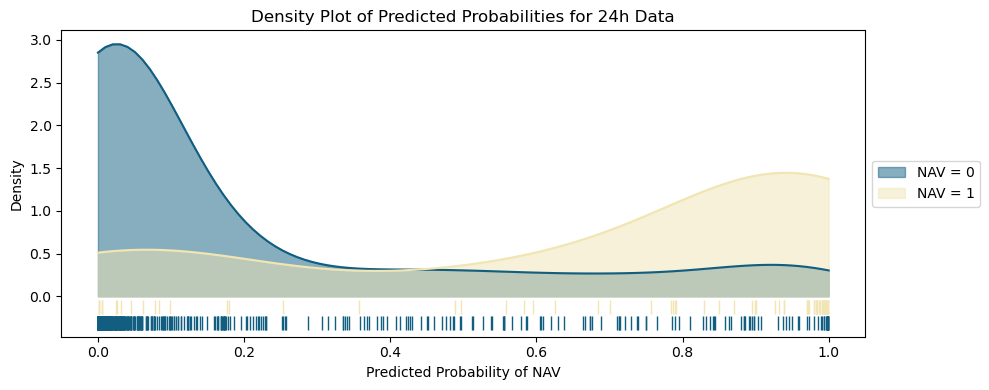

In [16]:
# Define the density functions
density0 = gaussian_kde(y_pred_prob[y_test == 0])
density1 = gaussian_kde(y_pred_prob[y_test == 1])

# Define the range of x values
x = np.linspace(0, 1, 100)

# Calculate the density values for plotting
density0_val = density0(x)
density1_val = density1(x)

# Create the plot with adjusted dimensions
plt.figure(figsize=(10, 4))  # Adjusted to make it wider and less tall
plt.fill_between(x, density0_val, alpha=0.5, color='#115e81', label='NAV = 0')
plt.fill_between(x, density1_val, alpha=0.5, color='#f1e5b4', label='NAV = 1')
plt.plot(x, density0_val, color='#115e81')
plt.plot(x, density1_val, color='#f1e5b4')

# Add rug plots for samples
# sns.rugplot(y_pred_prob[y_test == 0], color='#3FA2CE', alpha=0.5, height=0.05, label='Samples NAV = 0')
# sns.rugplot(y_pred_prob[y_test == 1], color='#F9BF66', alpha=0.5, height=0.05, label='Samples NAV = 1')

# Manually offset the NAV=1 rug plot by adjusting the y-position
plt.plot(y_pred_prob[y_test == 0], np.ones_like(y_pred_prob[y_test == 0]) * -0.31, '|', color='#115e81', markersize=10)
plt.plot(y_pred_prob[y_test == 1], np.ones_like(y_pred_prob[y_test == 1]) * -0.12, '|', color='#f1e5b4', markersize=10)

# Labeling the plot
plt.xlabel('Predicted Probability of NAV')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities for 24h Data')

# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

## MODEL -24H

In [6]:
n_features = 36
best_feature_selector = 'mRMR'

features_finales_24h = ranked_features['hr=-24'][best_feature_selector][:n_features]
features_finales_24h_nav = features_finales_24h.copy()
features_finales_24h_nav.extend(['NAV'])

In [7]:
df_training = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_training = df_training[df_training.hr==-24].reset_index(drop=True)
df_training = df_training[features_finales_24h_nav]

In [8]:
X = df_training.drop("NAV", axis=1).copy()
y = df_training["NAV"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
def objective(trial):
    # Espacio de hiperparámetros para CatBoost
    param_space = {
        'depth': trial.suggest_int('depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0, step=0.1)
    }

    # Hiperparámetros adicionales
    majority_proportion = trial.suggest_categorical('majority_proportion', [0.8, 0.9, 1.0, 1.1, 1.2])
    n_folds = trial.suggest_categorical('n_folds', [3, 4, 5])

    # Validación cruzada
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    pr_aucs = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx].copy(), X_train.iloc[valid_idx].copy()
        y_train_fold, y_valid_fold = y_train.iloc[train_idx].copy(), y_train.iloc[valid_idx].copy()

        # Imputación sin leakage
        imputer = IterativeImputer(max_iter=1000, random_state=42)
        X_train_fold = imputer.fit_transform(X_train_fold)
        X_valid_fold = imputer.transform(X_valid_fold)

        # Downsampling dentro del fold
        X_train_fold, y_train_fold = downsampling(X_train_fold, y_train_fold, majority_proportion=majority_proportion)

        # Entrenamiento y evaluación
        model = CatBoostClassifier(
            **param_space,
            verbose=0,
            random_state=42,
        )
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba = model.predict_proba(X_valid_fold)[:, 1]

        # PR-AUC
        pr_auc = average_precision_score(y_valid_fold, y_pred_proba)
        pr_aucs.append(pr_auc)

    return np.mean(pr_aucs)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-08-27 14:19:51,494] A new study created in memory with name: no-name-cc2e6c6d-c3a7-4de8-aa04-5b3392d3dd2a
[I 2025-08-27 14:20:34,417] Trial 0 finished with value: 0.31349759530163596 and parameters: {'depth': 4, 'learning_rate': 0.0031940349287913256, 'iterations': 100, 'l2_leaf_reg': 9.135966826758514, 'subsample': 0.8999999999999999, 'majority_proportion': 1.1, 'n_folds': 3}. Best is trial 0 with value: 0.31349759530163596.
[I 2025-08-27 14:23:55,731] Trial 1 finished with value: 0.3729928374987492 and parameters: {'depth': 6, 'learning_rate': 0.12005421282081928, 'iterations': 300, 'l2_leaf_reg': 1.2061816754065222, 'subsample': 0.7, 'majority_proportion': 0.8, 'n_folds': 5}. Best is trial 1 with value: 0.3729928374987492.
[I 2025-08-27 14:26:42,442] Trial 2 finished with value: 0.3243149076732407 and parameters: {'depth': 3, 'learning_rate': 0.0016724976233705813, 'iterations': 350, 'l2_leaf_reg': 8.50645484030835, 'subsample': 0.8999999999999999, 'majority_proportion': 1.1

In [ ]:
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

plot_parallel_coordinate(study)
plot_param_importances(study)

In [ ]:
best_params = study.best_params

# Puedes agregar los que estaban fuera de param_space si los usaste
best_majority_proportion = best_params.pop("majority_proportion")
best_n_folds = best_params.pop("n_folds")

print(f"Majority proportion: {best_majority_proportion}")
print(f"N-Folds: {best_n_folds}")
print(f"Parameters: {best_params}")

In [9]:
best_params = {
    'depth': 5, 
    'learning_rate': 0.017329985697213668, 
    'iterations': 500, 
    'l2_leaf_reg': 6.732343959458352, 
    'subsample': 0.7999999999999999
}

best_majority_proportion = 1.2
best_n_folds = 5

In [10]:
df_train = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_train_total = df_train.copy()
df_train = df_train[df_train.hr==-24].reset_index(drop=True)
df_train = df_train[features_finales_24h_nav]

X = df_train.drop("NAV", axis=1).copy()
y = df_train["NAV"].copy()
X_total = df_train_total["PatientID"].copy()
y_total = df_train_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

X_train_ds, y_train_ds = downsampling(X_train_imp, y_train, majority_proportion=best_majority_proportion)

# Entrenar el modelo con los mejores hiperparámetros
final_model = CatBoostClassifier(
    **best_params,
    verbose=0,
    random_state=42,
)

final_model.fit(X_train_ds, y_train_ds)

In [19]:
final_model.save_model("models/best_model_24h.cbm")

In [20]:
final_model = CatBoostClassifier()
final_model.load_model("models/best_model_24h.cbm")

In [11]:
df_test = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_test_total = df_test.copy()
df_test = df_test[df_test.hr==-24].reset_index(drop=True)
df_test = df_test[features_finales_24h_nav]

X = df_test.drop("NAV", axis=1).copy()
y = df_test["NAV"].copy()
X_total = df_test_total["PatientID"].copy()
y_total = df_test_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

In [12]:
y_pred_prob = final_model.predict_proba(X_test_imp)[:, 1]
y_pred = (y_pred_prob > 0.5).astype('int')

In [13]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm = np.flipud(cm)
cm = np.fliplr(cm)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_prob)
auc_ann = auc(fpr_ann, tpr_ann)

print(f"\tY PRED")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion matrix:\n",cm)
print(f"AUC: {auc_ann:.2f}\n")

	Y PRED
Accuracy: 0.83
Recall: 0.76
Confusion matrix:
 [[ 51  16]
 [ 81 416]]
AUC: 0.86



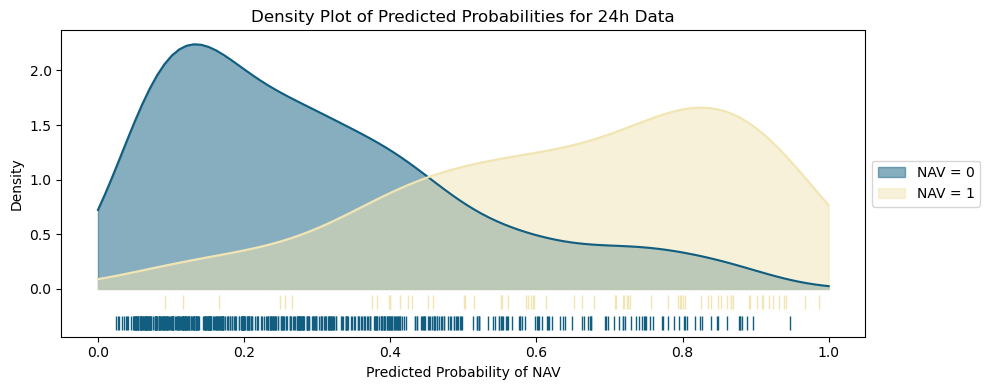

In [15]:
# Define the density functions
density0 = gaussian_kde(y_pred_prob[y_test == 0])
density1 = gaussian_kde(y_pred_prob[y_test == 1])

# Define the range of x values
x = np.linspace(0, 1, 100)

# Calculate the density values for plotting
density0_val = density0(x)
density1_val = density1(x)

# Create the plot with adjusted dimensions
plt.figure(figsize=(10, 4))  # Adjusted to make it wider and less tall
plt.fill_between(x, density0_val, alpha=0.5, color='#115e81', label='NAV = 0')
plt.fill_between(x, density1_val, alpha=0.5, color='#f1e5b4', label='NAV = 1')
plt.plot(x, density0_val, color='#115e81')
plt.plot(x, density1_val, color='#f1e5b4')

# Add rug plots for samples
# sns.rugplot(y_pred_prob[y_test == 0], color='#3FA2CE', alpha=0.5, height=0.05, label='Samples NAV = 0')
# sns.rugplot(y_pred_prob[y_test == 1], color='#F9BF66', alpha=0.5, height=0.05, label='Samples NAV = 1')

# Manually offset the NAV=1 rug plot by adjusting the y-position
plt.plot(y_pred_prob[y_test == 0], np.ones_like(y_pred_prob[y_test == 0]) * -0.31, '|', color='#115e81', markersize=10)
plt.plot(y_pred_prob[y_test == 1], np.ones_like(y_pred_prob[y_test == 1]) * -0.12, '|', color='#f1e5b4', markersize=10)

# Labeling the plot
plt.xlabel('Predicted Probability of NAV')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities for 24h Data')

# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

## MODEL -48H

In [20]:
n_features = 25
best_feature_selector = 'ModelBased_CatBoost'

features_finales_48h = ranked_features['hr=-48'][best_feature_selector][:n_features]
features_finales_48h_nav = features_finales_48h.copy()
features_finales_48h_nav.extend(['NAV'])

In [21]:
df = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_training = df[df.hr==-48].reset_index(drop=True)

lista_pacientes = df_training.PatientID.unique()
df_test_24 = df[(df.PatientID.isin(lista_pacientes)) & (df.hr==-24)].reset_index(drop=True)

df_training = df_training[features_finales_48h_nav]
df_test_24 = df_test_24[features_finales_48h_nav]

In [22]:
X = df_training.drop("NAV", axis=1).copy()
y = df_training["NAV"].copy()
X_24 = df_test_24.drop("NAV", axis=1).copy()
y_24 = df_test_24["NAV"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.2, random_state=42, stratify=y_24)

In [23]:
def objective(trial):
    # Espacio de hiperparámetros para CatBoost
    param_space = {
        'depth': trial.suggest_int('depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0, step=0.1)
    }

    # Hiperparámetros adicionales
    majority_proportion = trial.suggest_categorical('majority_proportion', [0.8, 0.9, 1.0, 1.1, 1.2])
    n_folds = trial.suggest_categorical('n_folds', [3, 4, 5])

    # Validación cruzada
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    pr_aucs = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx].copy(), X_train.iloc[valid_idx].copy()
        y_train_fold, y_valid_fold = y_train.iloc[train_idx].copy(), y_train.iloc[valid_idx].copy()
        X_train_fold_24, X_valid_fold_24 = X_train_24.iloc[train_idx].copy(), X_train_24.iloc[valid_idx].copy()
        y_train_fold_24, y_valid_fold_24 = y_train_24.iloc[train_idx].copy(), y_train_24.iloc[valid_idx].copy()

        # Imputación sin leakage
        imputer = IterativeImputer(max_iter=1000, random_state=42)
        X_train_fold = imputer.fit_transform(X_train_fold)
        # X_valid_fold = imputer.transform(X_valid_fold)
        X_valid_fold_24 = imputer.transform(X_valid_fold_24)

        # Downsampling dentro del fold
        X_train_fold, y_train_fold = downsampling(X_train_fold, y_train_fold, majority_proportion=majority_proportion)

        # Entrenamiento y evaluación
        model = CatBoostClassifier(
            **param_space,
            verbose=0,
            random_state=42,
        )
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_proba = model.predict_proba(X_valid_fold_24)[:, 1]

        # PR-AUC
        pr_auc = average_precision_score(y_valid_fold_24, y_pred_proba)
        pr_aucs.append(pr_auc)

    return np.mean(pr_aucs)

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-08-31 22:41:23,084] A new study created in memory with name: no-name-57a87662-0b88-405e-85dd-aa3306d4ac98
[I 2025-08-31 22:41:48,002] Trial 0 finished with value: 0.3983331048152428 and parameters: {'depth': 3, 'learning_rate': 0.008248433750545053, 'iterations': 300, 'l2_leaf_reg': 8.751168546623433, 'subsample': 1.0, 'majority_proportion': 1.2, 'n_folds': 5}. Best is trial 0 with value: 0.3983331048152428.
[I 2025-08-31 22:42:13,747] Trial 1 finished with value: 0.4050984696646861 and parameters: {'depth': 4, 'learning_rate': 0.004711738424051939, 'iterations': 350, 'l2_leaf_reg': 7.497091712117678, 'subsample': 1.0, 'majority_proportion': 1.0, 'n_folds': 5}. Best is trial 1 with value: 0.4050984696646861.
[I 2025-08-31 22:42:26,315] Trial 2 finished with value: 0.3956406509902602 and parameters: {'depth': 3, 'learning_rate': 0.0015553363246799832, 'iterations': 400, 'l2_leaf_reg': 4.817590886116173, 'subsample': 0.7, 'majority_proportion': 0.9, 'n_folds': 3}. Best is trial 1

In [69]:
best_params = study.best_params

# Puedes agregar los que estaban fuera de param_space si los usaste
best_majority_proportion = best_params.pop("majority_proportion")
best_n_folds = best_params.pop("n_folds")

print(f"Majority proportion: {best_majority_proportion}")
print(f"N-Folds: {best_n_folds}")
print(f"Parameters: {best_params}")

Majority proportion: 1.2
N-Folds: 3
Parameters: {'depth': 4, 'learning_rate': 0.016918242732133534, 'iterations': 200, 'l2_leaf_reg': 8.534044277665194, 'subsample': 0.7}


In [70]:
df_train = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_train_total = df_train.copy()
df_train = df_train[df_train.hr==-48].reset_index(drop=True)
df_train = df_train[features_finales_48h_nav]

X = df_train.drop("NAV", axis=1).copy()
y = df_train["NAV"].copy()
X_total = df_train_total["PatientID"].copy()
y_total = df_train_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

X_train_ds, y_train_ds = downsampling(X_train_imp, y_train, majority_proportion=best_majority_proportion)

# Entrenar el modelo con los mejores hiperparámetros
final_model = CatBoostClassifier(
    **best_params,
    verbose=0,
    random_state=42,
)

final_model.fit(X_train_ds, y_train_ds)

In [71]:
final_model.save_model("models/best_model_48h.cbm")

In [72]:
final_model = CatBoostClassifier()
final_model.load_model("models/best_model_48h.cbm")

In [79]:
df = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_test_total = df.copy()
df_train = df[df.hr==-48].reset_index(drop=True)
pacientes_48h = df_train.PatientID.unique()
df_test = df[(df.hr==-24) & (df.PatientID.isin(pacientes_48h))].reset_index(drop=True)
df_train = df_train[features_finales_48h_nav]
df_test = df_test[features_finales_48h_nav]

X = df_train.drop("NAV", axis=1).copy()
y = df_train["NAV"].copy()
X_24 = df_test.drop("NAV", axis=1).copy()
y_24 = df_test["NAV"].copy()
X_total = df_test_total["PatientID"].copy()
y_total = df_test_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.2, random_state=42, stratify=y_24)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test_24)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

In [80]:
y_pred_prob = final_model.predict_proba(X_test_imp)[:, 1]
y_pred = (y_pred_prob > 0.5).astype('int')

In [81]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm = np.flipud(cm)
cm = np.fliplr(cm)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_prob)
auc_ann = auc(fpr_ann, tpr_ann)

print(f"\tY PRED")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion matrix:\n",cm)
print(f"AUC: {auc_ann:.2f}\n")

	Y PRED
Accuracy: 0.75
Recall: 0.61
Confusion matrix:
 [[ 39  25]
 [102 347]]
AUC: 0.75



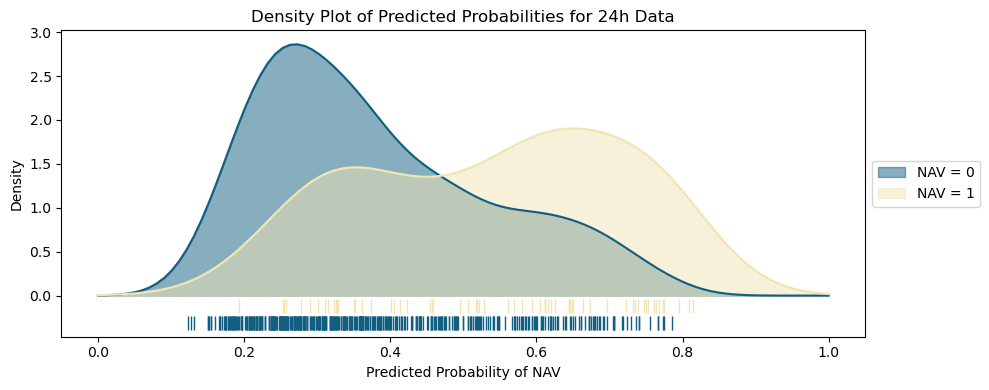

In [34]:
# Define the density functions
density0 = gaussian_kde(y_pred_prob[y_test == 0])
density1 = gaussian_kde(y_pred_prob[y_test == 1])

# Define the range of x values
x = np.linspace(0, 1, 100)

# Calculate the density values for plotting
density0_val = density0(x)
density1_val = density1(x)

# Create the plot with adjusted dimensions
plt.figure(figsize=(10, 4))  # Adjusted to make it wider and less tall
plt.fill_between(x, density0_val, alpha=0.5, color='#115e81', label='NAV = 0')
plt.fill_between(x, density1_val, alpha=0.5, color='#f1e5b4', label='NAV = 1')
plt.plot(x, density0_val, color='#115e81')
plt.plot(x, density1_val, color='#f1e5b4')

# Add rug plots for samples
# sns.rugplot(y_pred_prob[y_test == 0], color='#3FA2CE', alpha=0.5, height=0.05, label='Samples NAV = 0')
# sns.rugplot(y_pred_prob[y_test == 1], color='#F9BF66', alpha=0.5, height=0.05, label='Samples NAV = 1')

# Manually offset the NAV=1 rug plot by adjusting the y-position
plt.plot(y_pred_prob[y_test == 0], np.ones_like(y_pred_prob[y_test == 0]) * -0.31, '|', color='#115e81', markersize=10)
plt.plot(y_pred_prob[y_test == 1], np.ones_like(y_pred_prob[y_test == 1]) * -0.12, '|', color='#f1e5b4', markersize=10)

# Labeling the plot
plt.xlabel('Predicted Probability of NAV')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities for 24h Data')

# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()